In [100]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os
import pickle

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


### Read all the data

In [2]:
img_path = []
labels = []

for i in os.listdir("data/afhq"):
    for label in os.listdir(f"data/afhq/{i}"):
        for image in os.listdir(f"data/afhq/{i}/{label}"):
            img_path.append(f"data/afhq/{i}/{label}/{image}")
            labels.append(label)

data_df = pd.DataFrame(zip(img_path, labels), columns=["image", "label"])

data_df.head()
# print(data_df["label"].unique())

,image,label
0,data/afhq/train/cat/flickr_cat_000002.jpg,cat
1,data/afhq/train/cat/flickr_cat_000003.jpg,cat
2,data/afhq/train/cat/flickr_cat_000004.jpg,cat
3,data/afhq/train/cat/flickr_cat_000005.jpg,cat
4,data/afhq/train/cat/flickr_cat_000006.jpg,cat


### Split the data

In [3]:
train = data_df.sample(frac = 0.7)
test = data_df.drop(train.index)

val = test.sample(frac = 0.5)
test = test.drop(val.index)

print(train.shape, test.shape, val.shape)

(11291, 2) (2419, 2) (2420, 2)


In [4]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df["label"])

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe["label"])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image).to(device)

        return image, label

In [6]:
train_data = CustomImageDataset(dataframe=train, transform=transform)
test_data = CustomImageDataset(dataframe=test, transform=transform)
val_data = CustomImageDataset(dataframe=val, transform=transform)

### Visualize Image

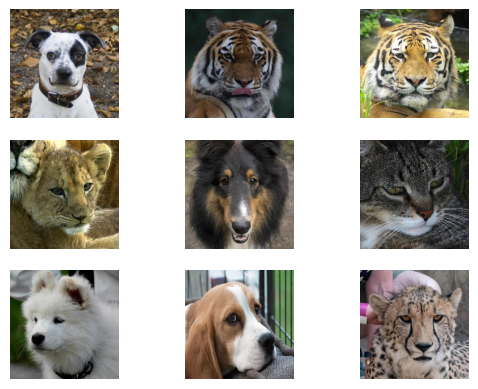

In [12]:
n_rows = 3
n_cols = 3

f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
    for col in range(n_cols):
        image = Image.open(data_df.sample(n = 1)['image'].iloc[0]).convert("RGB")
        axarr[row, col].imshow(image)
        axarr[row, col].axis('off')

plt.show()

In [13]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [14]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

In [21]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pooling = nn.MaxPool2d(2,2)

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

        self.linear = nn.Linear((128*16*16), 128)

        self.output = nn.Linear(128, len(data_df["label"].unique()))

    def forward(self, x):
        x = self.conv1(x)   # -> (32, 128, 128)
        x = self.pooling(x) # -> (32, 64, 64)
        x = self.relu(x)

        x = self.conv2(x)   # -> (64, 64, 64)
        x = self.pooling(x) # -> (64, 32, 32)
        x = self.relu(x)

        x = self.conv3(x)   # -> (128, 32, 32)
        x = self.pooling(x) # -> (128, 16, 16)
        x = self.relu(x)

        x = self.flatten(x)
        x = self.linear(x)
        x = self.output(x)
        return x


In [22]:
model = Net().to(device)

In [25]:
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [30]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_acc_val = 0
    total_loss_train = 0
    total_loss_val = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()

        train_loss.backward()

        train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()

        total_acc_train+= train_acc
        optimizer.step()

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()

            val_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
            total_acc_val+= val_acc

    total_loss_train_plot.append(round(total_loss_train / 1000, 4))
    total_loss_validation_plot.append(round(total_loss_val / 1000, 4))

    total_acc_train_plot.append(round(total_acc_train / train_data.__len__()*100, 4))
    total_acc_validation_plot.append(round(total_acc_val / val_data.__len__()*100, 4))

    print(f"Epoch {epoch+1}/{EPOCHS}\n\t Train Loss:{round(total_loss_train / 1000, 4)}, Train Accuracy: {round(total_acc_train / train_data.__len__()*100, 4)}%\n\t Validation Loss: {round(total_loss_val / 1000, 4)}, Validation Accuracy: {round(total_acc_val / val_data.__len__()*100, 4)}")


Epoch 1/10
	 Train Loss:0.1175, Train Accuracy: 93.9244%
	 Validation Loss: 0.0247, Validation Accuracy: 93.843
Epoch 2/10
	 Train Loss:0.0777, Train Accuracy: 96.1208%
	 Validation Loss: 0.0218, Validation Accuracy: 94.7521
Epoch 3/10
	 Train Loss:0.0574, Train Accuracy: 97.1836%
	 Validation Loss: 0.0182, Validation Accuracy: 95.4959
Epoch 4/10
	 Train Loss:0.0394, Train Accuracy: 98.0338%
	 Validation Loss: 0.0174, Validation Accuracy: 95.8264
Epoch 5/10
	 Train Loss:0.031, Train Accuracy: 98.5829%
	 Validation Loss: 0.0167, Validation Accuracy: 95.9917
Epoch 6/10
	 Train Loss:0.0225, Train Accuracy: 98.9018%
	 Validation Loss: 0.0188, Validation Accuracy: 96.0744
Epoch 7/10
	 Train Loss:0.0166, Train Accuracy: 99.2118%
	 Validation Loss: 0.0189, Validation Accuracy: 96.2397
Epoch 8/10
	 Train Loss:0.0119, Train Accuracy: 99.4509%
	 Validation Loss: 0.0251, Validation Accuracy: 94.9587
Epoch 9/10
	 Train Loss:0.0096, Train Accuracy: 99.6015%
	 Validation Loss: 0.0229, Validation Acc

In [32]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for inputs, labels in test_loader:
        predictions = model(inputs)

        acc = (torch.argmax(predictions, axis=1) == labels).sum().item()
        total_acc_test+= acc
        test_loss = criterion(predictions, labels)
        total_loss_test += test_loss.item()

print(f"Accuracy Score is:{round(total_acc_test / test_data.__len__()*100, 4)}% and Loss is {round(total_loss_test /1000, 4)}%")

Accuracy Score is:95.742% and Loss is 0.0254%


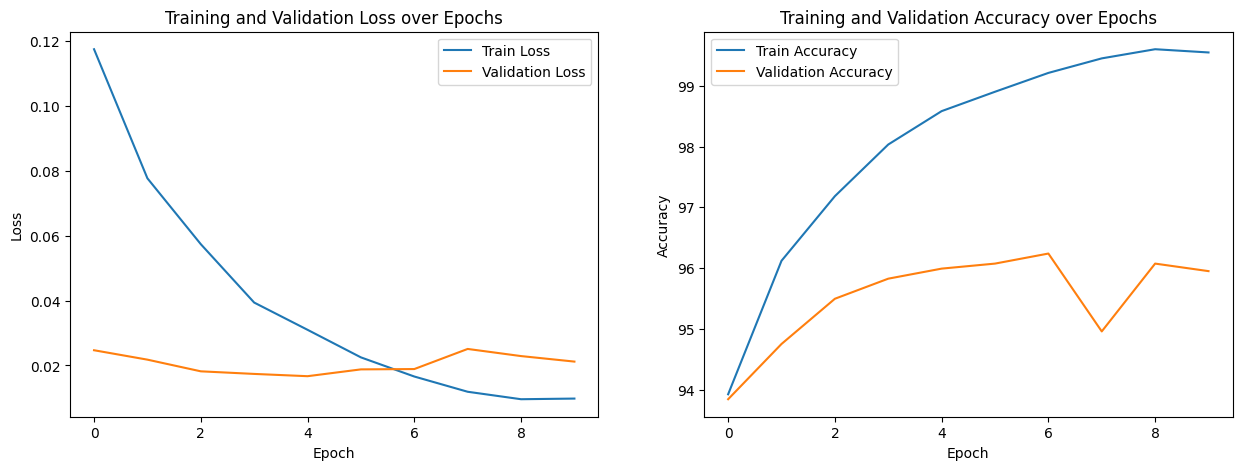

In [36]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label="Train Loss")
axs[0].plot(total_loss_validation_plot, label="Validation Loss")
axs[0].set_title("Training and Validation Loss over Epochs")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(total_acc_train_plot, label="Train Accuracy")
axs[1].plot(total_acc_validation_plot, label="Validation Accuracy")
axs[1].set_title("Training and Validation Accuracy over Epochs")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.show()

In [64]:
# 1 - read img
# 2 - Transform using transform object
# 3 - predict though the model
# 4 - inverse transform by lable encoder

def predict_image(img_path):
    image = Image.open(img_path).convert("RGB")
    image = transform(image).to(device)
    prediction = model(image.unsqueeze(0))
    prediction = torch.argmax(prediction, axis=1).item()

    return label_encoder.inverse_transform([prediction])

In [76]:
predict_image("photo-1574158622682-e40e69881006.jpg")

array(['cat'], dtype=object)

### Save the model

In [81]:
torch.save(model.state_dict(), "animal_faces_model.pth")

### Load the model

In [92]:
model_load = Net().to(device)

model_load.load_state_dict(torch.load("animal_faces_model.pth"))
model_load.eval()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=32768, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=3, bias=True)
)

In [94]:
def predict_image_load(img_path):
    image = Image.open(img_path).convert("RGB")
    image = transform(image).to(device)
    prediction = model_load(image.unsqueeze(0))
    prediction = torch.argmax(prediction, axis=1).item()

    return label_encoder.inverse_transform([prediction])

predict_image_load("photo-1574158622682-e40e69881006.jpg")

array(['cat'], dtype=object)

In [102]:
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

torch.save(model.state_dict(), "animal_faces_model.pth")